## Find isopycnal (x,y,t)

Assumes monotonically increasing density with depth

A little in-accurate - tells you depth of top of cell where cell below has density greater than target density

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35985/status,
Dashboard: /proxy/35985/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43167,Workers: 4
Dashboard: /proxy/35985/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:46207,Total threads: 4
Dashboard: /proxy/36137/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41593,


In [9]:
expt = '01deg_jra55v13_ryf9091'
variable = 'pot_rho_2'
start_time = '2170-01-01'
end_time = '2170-12-31'
pot_rho_2 = cc.querying.getvar(expt, variable, session, start_time = start_time, end_time = end_time)
pot_rho_2 = pot_rho_2.sel(time = slice(start_time, end_time))

In [13]:
# load cell thickness
dzt = cc.querying.getvar(expt, 'dzt', session, start_time = start_time, end_time = end_time, ncfile = 'ocean.nc')
dzt = dzt.sel(time = slice(start_time, end_time))

In [14]:
pot_rho_2

<xarray.DataArray 'pot_rho_2' (time: 12, st_ocean: 75, yt_ocean: 2700,
                               xt_ocean: 3600)>
dask.array<getitem, shape=(12, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 2170-01-16 12:00:00 ... 2170-12-16 12:00:00
Attributes:
    long_name:      potential density referenced to 2000 dbar
    units:          kg/m^3
    valid_range:    [-1.e+01  1.e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf90...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration under th...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...

In [15]:
dzt

<xarray.DataArray 'dzt' (time: 12, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<getitem, shape=(12, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 2170-01-16 12:00:00 ... 2170-12-16 12:00:00
Attributes: (12/13)
    long_name:      t-cell thickness
    units:          m
    valid_range:    [-1.e+01  1.e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf90...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration under th...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...

In [21]:
target_rho = 1036

In [25]:
lighter_densities = dzt.where(pot_rho_2 < target_rho)
biggest_rho_id = lighter_densities.idxmax('st_ocean')

In [22]:
biggest_rho_id_next_level = biggest_rho_id+1
partial_inclusion = dzt.where(dzt.st_ocean == dzt.st_ocean[biggest_rho_id_next_level])*(pot_rho

isopycnal_depth = lighter_densities.sum('st_ocean')

In [23]:
%%time
isopycnal_depth.load()

CPU times: user 1min 16s, sys: 4.72 s, total: 1min 21s
Wall time: 2min 7s


<xarray.DataArray 'dzt' (time: 12, yt_ocean: 2700, xt_ocean: 3600)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) object 2170-01-16 12:00:00 ... 2170-12-16 12:00:00

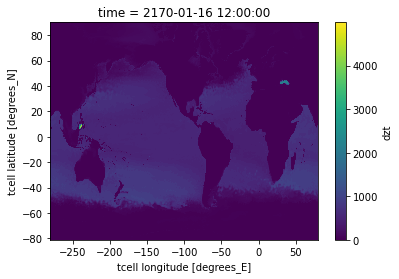

In [24]:
isopycnal_depth.isel(time = 0).plot()